In [1]:
"""
https://www.kaggle.com/code/aronpollner/galilee-dead-sea
"""

'\nhttps://www.kaggle.com/code/aronpollner/galilee-dead-sea\n'

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import os
import json

%matplotlib inline


In [3]:
with open('./dataset/datastore_search') as f:
  dataset_kinneret = json.load(f)

In [4]:
filtered_kinneret=(dataset_kinneret['result']['records'])
df_kinneret=pd.DataFrame(filtered_kinneret)
print(df_kinneret)

         _id          Survey_Date  Kinneret_Level
0          1  2024-10-29T00:00:00        -211.120
1          2  2024-10-28T00:00:00        -211.115
2          3  2024-10-27T00:00:00        -211.110
3          4  2024-10-26T00:00:00        -211.100
4          5  2024-10-25T00:00:00        -211.090
...      ...                  ...             ...
10690  10691  1966-11-01T00:00:00        -210.390
10691  10692  1966-10-15T00:00:00        -210.320
10692  10693  1966-10-01T00:00:00        -210.270
10693  10694  1966-09-15T00:00:00        -210.130
10694  10695  1966-09-01T00:00:00        -210.020

[10695 rows x 3 columns]


<Axes: xlabel='Survey_Date', ylabel='Kinneret_Level'>

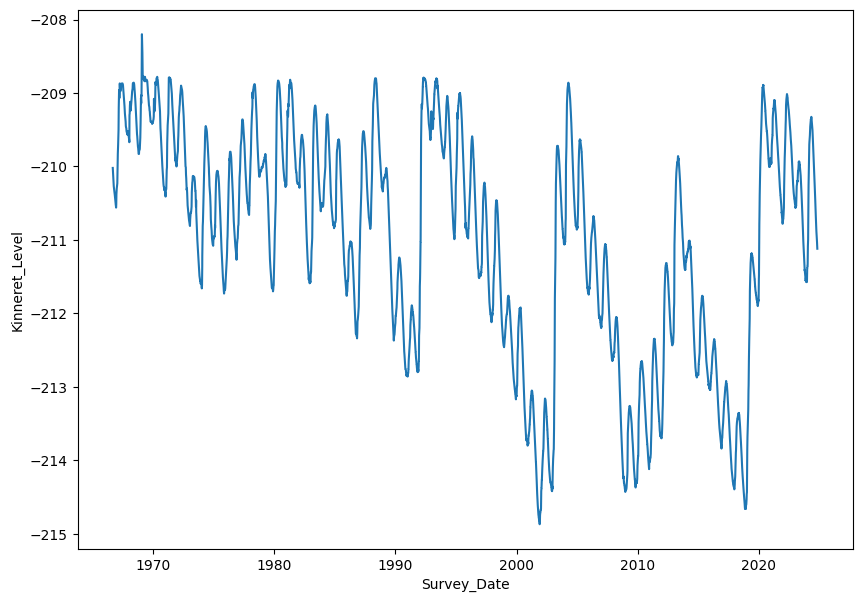

In [5]:
df_kinneret['Kinneret_Level']=df_kinneret['Kinneret_Level'].astype('float64')
df_kinneret["Survey_Date"] = pd.to_datetime(df_kinneret["Survey_Date"], format='ISO8601')
plt.figure(figsize=(10,7))
sns.lineplot(x=df_kinneret['Survey_Date'], y=df_kinneret.loc[:,'Kinneret_Level'])

In [6]:
df_kinneret = df_kinneret.sort_values('Survey_Date').reset_index().drop(['index','_id'],axis=1)
print(df_kinneret)
min_level = df_kinneret['Kinneret_Level'].min()
max_level = df_kinneret['Kinneret_Level'].max()
print(f"min: {min_level} max: {max_level}")

      Survey_Date  Kinneret_Level
0      1966-09-01        -210.020
1      1966-09-15        -210.130
2      1966-10-01        -210.270
3      1966-10-15        -210.320
4      1966-11-01        -210.390
...           ...             ...
10690  2024-10-25        -211.090
10691  2024-10-26        -211.100
10692  2024-10-27        -211.110
10693  2024-10-28        -211.115
10694  2024-10-29        -211.120

[10695 rows x 2 columns]
min: -214.87 max: -208.2


In [7]:
input_data = df_kinneret.copy(deep=True)
input_data['month'] = input_data['Survey_Date'].dt.month
input_data = pd.get_dummies(input_data, columns=['month'])
input_data = input_data.drop(['Survey_Date'],axis=1)
targets = input_data['Kinneret_Level'].values
print(input_data)
print(targets)

       Kinneret_Level  month_1  month_2  month_3  month_4  month_5  month_6  \
0            -210.020    False    False    False    False    False    False   
1            -210.130    False    False    False    False    False    False   
2            -210.270    False    False    False    False    False    False   
3            -210.320    False    False    False    False    False    False   
4            -210.390    False    False    False    False    False    False   
...               ...      ...      ...      ...      ...      ...      ...   
10690        -211.090    False    False    False    False    False    False   
10691        -211.100    False    False    False    False    False    False   
10692        -211.110    False    False    False    False    False    False   
10693        -211.115    False    False    False    False    False    False   
10694        -211.120    False    False    False    False    False    False   

       month_7  month_8  month_9  month_10  month_1

Kinneret Prediction

In [8]:
train_size = int(len(input_data) * 0.8)

T = 10
N = len(input_data) - T
D = input_data.shape[1]
print(N,D,T)

# Normalization
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

10685 13 10


In [9]:
train_X = np.zeros((train_size,T,D),dtype='float32')
train_Y = np.zeros((train_size,1),dtype='float32')

for t in range(train_size):
    train_X[t,:,:] = input_data[t:t+T]
    train_Y[t] = targets[t+T]

test_X = np.zeros((N-train_size,T,D),dtype='float64')
test_Y = np.zeros((N-train_size,1),dtype='float64')

for i in range(N - train_size):
    t = i + train_size
    test_X[i, :, :] = input_data[t:t+T]
    test_Y[i] = targets[t+T]

In [10]:
train_X = torch.from_numpy(train_X.astype(np.float32)).to(device='cuda')
train_Y = torch.from_numpy(train_Y.astype(np.float32)).to(device='cuda')
test_X = torch.from_numpy(test_X.astype(np.float32)).to(device='cuda')
test_Y = torch.from_numpy(test_Y.astype(np.float32)).to(device='cuda')

In [11]:
import torch
from torch import nn
class LSTM(nn.Module):
    def __init__(self,input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM,self).__init__()
        self.M = hidden_dim
        self.L = layer_dim

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,X):
        h0 = torch.zeros(self.L, X.size(0), self.M, device='cuda')
        c0 = torch.zeros(self.L, X.size(0), self.M, device='cuda')
        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1,:])
        return out

In [12]:
lstm = LSTM(D,256,2,1).to(device='cuda')

In [13]:
def train(model, learning_rate, train_X, train_Y, test_X, test_Y, epochs = 200, batch_size = 128):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4,momentum=0.8)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    dataset = TensorDataset(train_X, train_Y)
    dataloader = DataLoader(dataset,256,shuffle=False)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            #print(f'Batch Loss: {loss.item():.4f}')
            running_loss += loss.item() * batch_X.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)

        test_outputs = model(test_X)
        test_loss = criterion(test_outputs,test_Y)
        test_losses[epoch] = test_loss.item()

        if (epoch+1) % 50 == 0 : print(f'Epoch [{epoch+1}/{epochs}] Average Loss: {epoch_loss:.4f} Test Loss: {test_loss:.4f}')
        train_losses[epoch] = epoch_loss
    return train_losses, test_losses

In [14]:
train_losses, test_losses = train(lstm,
                                    0.0001,
                                    train_X,
                                    train_Y,
                                    test_X,
                                    test_Y,
                                    epochs=350)

Epoch [50/350] Average Loss: 3.2770 Test Loss: 6.9998
Epoch [100/350] Average Loss: 3.2301 Test Loss: 6.9035
Epoch [150/350] Average Loss: 3.1030 Test Loss: 6.6259
Epoch [200/350] Average Loss: 1.3583 Test Loss: 2.7692
Epoch [250/350] Average Loss: 0.2493 Test Loss: 0.3431
Epoch [300/350] Average Loss: 0.1186 Test Loss: 0.1193
Epoch [350/350] Average Loss: 0.0784 Test Loss: 0.0656


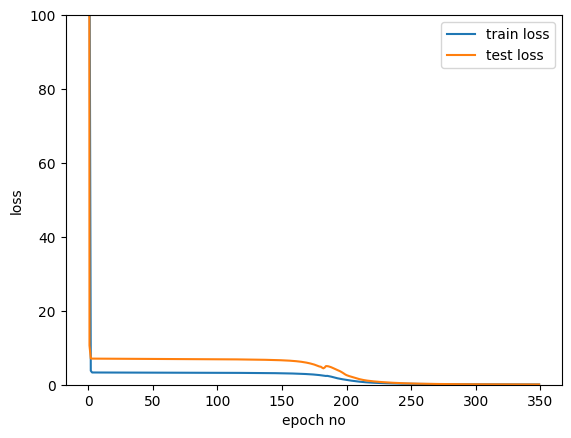

In [15]:
ax = plt.gca()
ax.set_ylim([0, 100])
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

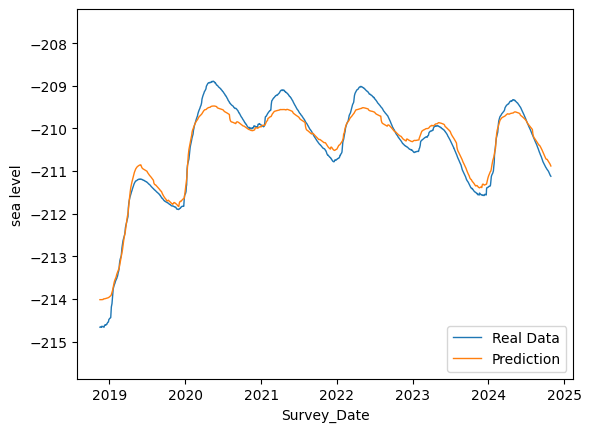

In [19]:
test_target = test_X.cpu().detach().numpy()
test_predictions = []
for i in range(len(test_target)):
    input_ = test_X[i].reshape(1,T,D)
    p = lstm(input_)[0,0].item()
    test_predictions.append(p)

plot_len = len(test_predictions)
plot_df = df_kinneret[['Survey_Date', 'Kinneret_Level']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('Survey_Date', inplace=True)

ax = plt.gca()
ax.set_ylim([min_level - 1, max_level + 1])

plt.plot(plot_df['Kinneret_Level'], label='Real Data', linewidth=1)
plt.plot(plot_df['prediction'], label='Prediction', linewidth=1)
plt.xlabel('Survey_Date')
plt.ylabel('sea level')
plt.legend(loc='lower right')

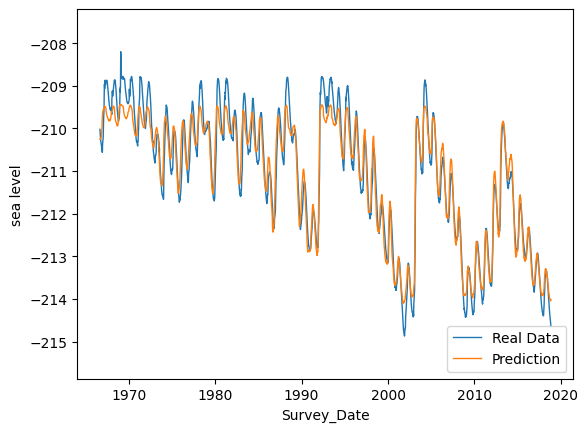

In [20]:
test_target = train_X.cpu().detach().numpy()
test_predictions = []
for i in range(len(test_target)):
    input_ = train_X[i].reshape(1,T,D)
    p = lstm(input_)[0,0].item()
    test_predictions.append(p)

plot_len = len(test_predictions)
plot_df = df_kinneret[['Survey_Date', 'Kinneret_Level']].copy(deep=True)
plot_df = plot_df.iloc[:plot_len]
plot_df['prediction'] = test_predictions
plot_df.set_index('Survey_Date', inplace=True)

ax = plt.gca()
ax.set_ylim([min_level - 1, max_level + 1])

plt.plot(plot_df['Kinneret_Level'], label='Real Data', linewidth=1)
plt.plot(plot_df['prediction'], label='Prediction', linewidth=1)
plt.xlabel('Survey_Date')
plt.ylabel('sea level')
plt.legend(loc='lower right')